### Import library / packages

In [ ]:
import os
import urllib.request
import zipfile

import numpy as np
import tensorflow as tf

import string
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD

from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
# from sklearn.metrics import confusion_matrix

# Download and extract the dataset

In [ ]:
url = "https://github.com/onesinus/datasets/raw/main/brain_tumor_detection.zip"
filename = "brain_tumor_detection.zip"
dataset_dir = "/content/dataset"  # Directory to store extracted data

# Create the directory if it doesn't exist
os.makedirs(dataset_dir, exist_ok=True)

if not os.path.exists(filename):
  print("Downloading dataset...")
  urllib.request.urlretrieve(url, filename)
  print("Download complete.")

# Extract the downloaded zip file
if os.path.exists(filename):
  print("Extracting dataset...")
  with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall(dataset_dir)
  os.remove(filename)  # Remove downloaded zip
  print("Extraction complete.")

Download complete.
Extracting dataset...
Extraction complete.


# Define label mapping

In [ ]:
label_map = {'0': 0, '1': 1, '2': 2}  # Modify if class labels are encoded differently

# Image dimensions (adjust if images have different sizes)
img_width, img_height = 139, 132  # Example size, adjust based on your data

# Data augmentation (optional, experiment to see if it improves performance)
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Loads images and labels from separate directories

In [ ]:
def load_data(data_dir, images_dir_name, labels_dir_name, label_map):
  """Loads images and labels from separate directories, handling multiple labels per file."""
  images = []
  labels = []
  for filename in os.listdir(os.path.join(data_dir, images_dir_name)):
    if filename.endswith(".jpg"):
      img_path = os.path.join(data_dir, images_dir_name, filename)
      img = tf.keras.preprocessing.image.load_img(img_path, target_size=(img_width, img_height))
      img_array = tf.keras.preprocessing.image.img_to_array(img)
      img_array = img_array / 255.0  # Normalize pixel values

      label_filename = os.path.splitext(filename)[0] + ".txt"  # Remove extension and add .txt
      label_path = os.path.join(data_dir, labels_dir_name, label_filename)

      with open(label_path, 'r') as f:
        label_lines = f.readlines()  # Read all lines in the label file

      # Assuming multiple labels per line (modify if different)
      one_hot_labels = np.zeros(len(label_map))  # Initialize one-hot encoded labels
      for line in label_lines:
        label_str = line.strip()
        label_values = label_str.split()
        class_value = label_values[0]
        # print(label_str)
        if class_value in label_map:
          label_index = label_map[class_value]
          one_hot_labels[label_index] = 1.0  # Set corresponding label to 1 in one-hot vector

      images.append(img_array)
      labels.append(one_hot_labels)

  return np.array(images), np.array(labels)

# Load training and validation data (assuming separate directories)
train_images, train_labels = load_data(dataset_dir, 'Brain Tumor Detection/train/images', 'Brain Tumor Detection/train/labels', label_map)
validation_images, validation_labels = load_data(dataset_dir, 'Brain Tumor Detection/valid/images', 'Brain Tumor Detection/valid/labels', label_map)
test_images, test_labels = load_data(dataset_dir, 'Brain Tumor Detection/test/images', 'Brain Tumor Detection/test/labels', label_map)

# Create training and validation generators
train_generator = train_datagen.flow(train_images, train_labels, batch_size=100)
# time.sleep(1)
validation_generator = valid_datagen.flow(validation_images, validation_labels, batch_size=100)
# time.sleep(1)
test_generator = test_datagen.flow(test_images, test_labels, batch_size=100)

In [ ]:
# Print shapes for training data
print(f"Shape of X (training images): {train_images.shape}")
print(f"Shape of Y (training labels): {train_labels.shape}")

# print(f"Training Image [0]: {train_images[0]}")
print(f"Training Label [0]: {train_labels[0]}")

for i in range(1,10):
  print(f"Training Label [{i}]: {train_labels[i]}")

# Print shapes for validation data
print(f"Shape of X (validation images): {validation_images.shape}")
print(f"Shape of Y (validation labels): {validation_labels.shape}")

# Assuming you have loaded test data using the same approach
print(f"Shape of X (test images): {test_images.shape}")
print(f"Shape of Y (test labels): {test_labels.shape}")

Shape of X (training images): (6930, 139, 132, 3)
Shape of Y (training labels): (6930, 3)
Training Label [0]: [1. 1. 1.]
Training Label [1]: [0. 1. 0.]
Training Label [2]: [0. 1. 0.]
Training Label [3]: [1. 1. 1.]
Training Label [4]: [0. 1. 0.]
Training Label [5]: [0. 1. 1.]
Training Label [6]: [0. 1. 1.]
Training Label [7]: [0. 1. 0.]
Training Label [8]: [1. 1. 1.]
Training Label [9]: [1. 1. 1.]
Shape of X (validation images): (1980, 139, 132, 3)
Shape of Y (validation labels): (1980, 3)
Shape of X (test images): (990, 139, 132, 3)
Shape of Y (test labels): (990, 3)


# Define CNN models

In [ ]:
models_configurations = [
    # Configuration a
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ],
    # Configuration b
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ],
    # Configuration c
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ],
    # Configuration d
    [
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ]
]

In [ ]:
# Define lists to store accuracy and loss values
train_accs = []
val_accs = []
test_accs = []
train_losses = []
val_losses = []
test_losses = []

# Define alphabet letters for model labels
model_labels = list(string.ascii_lowercase)[:len(models_configurations)]

def create_model(layers_config, optimizer):
    model = Sequential()
    for layer_config in layers_config:
        model.add(layer_config)

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define a function to train and evaluate models
def train_and_evaluate(models_configurations, optimizer):
    train_accs = []
    val_accs = []
    test_accs = []
    train_losses = []
    val_losses = []
    test_losses = []

    for i, layers_config in enumerate(models_configurations):
        print(f"Training Model {chr(97 + i)}:")
        model = create_model(layers_config, optimizer)
        # print(model.summary())
        history = model.fit(
            train_generator,
            steps_per_epoch=len(train_generator),
            # epochs=1,
            epochs=5,
            validation_data=validation_generator,
            validation_steps=len(validation_generator)
        )

        # Evaluate the model on the test set (optional)
        test_loss, test_acc = model.evaluate(test_generator)
        print(f"Model {chr(97 + i)}: Test Accuracy = {test_acc:.4f}, Loss: {test_loss}")

        # Append accuracy and loss values to lists
        train_accs.append(history.history['accuracy'][-1])
        val_accs.append(history.history['val_accuracy'][-1])
        train_losses.append(history.history['loss'][-1])
        val_losses.append(history.history['val_loss'][-1])
        test_accs.append(test_acc)
        test_losses.append(test_loss)

        # Calculate confusion matrix # There is an error here
        # y_pred_probs = model.predict(test_generator)
        # y_pred = np.argmax(y_pred_probs, axis=1)
        # y_true = test_generator.classes # AttributeError: 'NumpyArrayIterator' object has no attribute 'classes'
        # cm = confusion_matrix(y_true, y_pred)

        # # Plot confusion matrix
        # plt.figure(figsize=(8, 6))
        # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        # plt.title(f'Confusion Matrix - Model {chr(97 + i)}')
        # plt.xlabel('Predicted Label')
        # plt.ylabel('True Label')
        # plt.show()

    return train_accs, val_accs, test_accs, train_losses, val_losses, test_losses

In [ ]:
def plot_comparison(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, model_labels, optimizer):
    """
    Plot accuracy and loss comparison for different models.

    Args:
    train_accs (list): List of training accuracies for each model.
    val_accs (list): List of validation accuracies for each model.
    test_accs (list): List of test accuracies for each model.
    train_losses (list): List of training losses for each model.
    val_losses (list): List of validation losses for each model.
    test_losses (list): List of test losses for each model.
    model_labels (list): List of model labels.
    optimizer (str): The name of the optimizer used.
    """
    # Plot accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(model_labels, train_accs, label='Train Accuracy', marker='o')
    plt.plot(model_labels, val_accs, label='Validation Accuracy', marker='o')
    plt.plot(model_labels, test_accs, label='Test Accuracy', marker='o')
    plt.title(f'Model Accuracy Comparison with {optimizer.capitalize()} Optimizer')
    plt.xlabel('Model Configuration')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot loss values
    plt.subplot(1, 2, 2)
    plt.plot(model_labels, train_losses, label='Train Loss', marker='o')
    plt.plot(model_labels, val_losses, label='Validation Loss', marker='o')
    plt.plot(model_labels, test_losses, label='Test Loss', marker='o')
    plt.title(f'Model Loss Comparison with {optimizer.capitalize()} Optimizer')
    plt.xlabel('Model Configuration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Modeling SGD

In [ ]:
# # Define optimizers to try
# optimizers = ['sgd']

# # Iterate over each optimizer
# for optimizer in optimizers:
#     print(f"\nTraining models with optimizer: {optimizer.capitalize()}")
#     train_accs, val_accs, test_accs, train_losses, val_losses, test_losses = train_and_evaluate(models_configurations, optimizer)

#     plot_comparison(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, model_labels, optimizer)

In [ ]:
    # plot_comparison([0.7235, 0.7235, 0.7235, 0.7235], [0.7374, 0.7374, 0.7374, 0.7374], [0.7084, 0.7084, 0.7084, 0.7084], [0.5898, 0.5899, 0.5898, 0.5898], [0.5759, 0.5760, 0.5763, 0.5765], [0.6043, 0.6037, 0.6038, 0.6038], ["a", "b", "c", "d"], "SGD")

# Modeling Adam

In [ ]:
# # Define optimizers to try
# optimizers = ['adam']

# # Iterate over each optimizer
# for optimizer in optimizers:
#     print(f"\nTraining models with optimizer: {optimizer.capitalize()}")
#     train_accs, val_accs, test_accs, train_losses, val_losses, test_losses = train_and_evaluate(models_configurations, optimizer)

In [ ]:
    # plot_comparison(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, model_labels, optimizer)

# Modeling Adagrad

In [ ]:
# # Define optimizers to try
# optimizers = ['adagrad']

# # Iterate over each optimizer
# for optimizer in optimizers:
#    print(f"\nTraining models with optimizer: {optimizer.capitalize()}")
#    train_accs, val_accs, test_accs, train_losses, val_losses, test_losses = train_and_evaluate(models_configurations, optimizer)
#    plot_comparison(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, model_labels, optimizer)

In [ ]:
# plot_comparison(
#     [0.7235, 0.7235, 0.7235, 0.7235],
#     [0.7374, 0.7374, 0.7374, 0.7374],
#     [0.7084, 0.7084, 0.7084, 0.7084],
#     [0.5895, 0.5896, 0.5896, 0.5896],
#     [0.5761, 0.5761, 0.5761, 0.5761],
#     [0.6040, 0.6041, 0.6041, 0.6041],
#     ["a", "b", "c", "d"],
#     "adagrad"
# )

# Modeling Adadelta

In [ ]:
# # Define optimizers to try
# optimizers = ['adadelta']

# # Iterate over each optimizer
# for optimizer in optimizers:
#    print(f"\Training models with optimizer: {optimizer.capitalize()}")
#    train_accs, val_accs, test_accs, train_losses, val_losses, test_losses = train_and_evaluate(models_configurations, optimizer)
#    plot_comparison(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, model_labels, optimizer)

# Dropout 20% pada FC

In [ ]:
# models_configurations = [
#     # Configuration a
#     [
#         Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.2),  # Dropout 20%
#         Dense(1, activation='sigmoid')
#     ],
#     # Configuration b
#     [
#         Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.2),
#         Dense(1, activation='sigmoid')
#     ],
#     # Configuration c
#     [
#         Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.2),  # Dropout 20%
#         Dense(1, activation='sigmoid')
#     ],
#     # Configuration d
#     [
#         Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         Conv2D(256, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.2),
#         Dense(1, activation='sigmoid')
#     ]
# ]

# # Define optimizers to try
# # optimizers = ['sgd', 'adam', 'adagrad', 'adadelta']
# optimizers = ['adam', 'adagrad', 'adadelta']

# # Iterate over each optimizer
# for optimizer in optimizers:
#     print(f"\nTraining models with optimizer: {optimizer.capitalize()}")
#     train_accs, val_accs, test_accs, train_losses, val_losses, test_losses = train_and_evaluate(models_configurations, optimizer)
#     plot_comparison(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, model_labels, optimizer)

# Dropout 50% pada FC

In [ ]:
# models_configurations = [
#     # Configuration a
#     # [
#     #     Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#     #     MaxPooling2D((2, 2)),
#     #     Flatten(),
#     #     Dense(128, activation='relu'),
#     #     Dropout(0.5),  # Dropout 50%
#     #     Dense(1, activation='sigmoid')
#     # ],
#     # Configuration b
#     [
#         Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(1, activation='sigmoid')
#     ],
#     # Configuration c
#     [
#         Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),  # Dropout 50%
#         Dense(1, activation='sigmoid')
#     ],
#     # Configuration d
#     [
#         Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
#         Conv2D(64, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Conv2D(128, (3, 3), activation='relu'),
#         Conv2D(256, (3, 3), activation='relu'),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dropout(0.5),
#         Dense(1, activation='sigmoid')
#     ]
# ]

# # Define optimizers to try
# # optimizers = ['sgd', 'adam', 'adagrad', 'adadelta']
# optimizers = ['adadelta']

# # Iterate over each optimizer
# for optimizer in optimizers:
#     print(f"\nTraining models with optimizer: {optimizer.capitalize()}")
#     train_accs, val_accs, test_accs, train_losses, val_losses, test_losses = train_and_evaluate(models_configurations, optimizer)
#     plot_comparison(train_accs, val_accs, test_accs, train_losses, val_losses, test_losses, model_labels, optimizer)

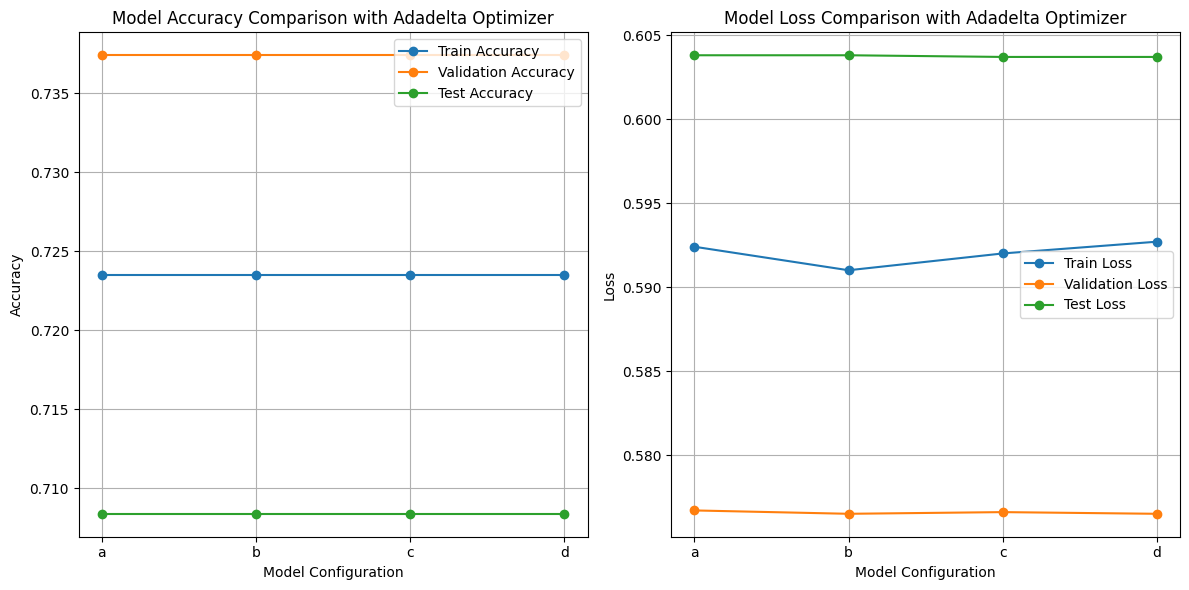

In [ ]:
# plot_comparison(
#     [0.7235, 0.7235, 0.7235, 0.7235],
#     [0.7374, 0.7374, 0.7374, 0.7374],
#     [0.7084, 0.7084, 0.7084, 0.7084],
#     [0.5924, 0.5910, 0.5920, 0.5927],
#     [0.5767, 0.5765, 0.5766, 0.5765],
#     [0.6038, 0.6038, 0.6037, 0.6037],
#     ["a", "b", "c", "d"],
#     "adadelta"
# )

# Keras DCNN Model

In [ ]:
# # Select 3 pre-trained models
# # pretrained_models = [VGG16, ResNet50, MobileNetV2]
# pretrained_models = [MobileNetV2]

# # Define input shape based on your data
# input_shape = (img_width, img_height, 3)

# # Function to create model without transfer learning
# def create_model_from_scratch():
#     model = Sequential([
#         Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
#         MaxPooling2D((2, 2)),
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
#     return model

# # Function to create model with transfer learning without fine-tuning
# def create_model_transfer_learning(model_type):
#     base_model = model_type(weights='imagenet', include_top=False, input_shape=input_shape)
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
#     return model

# # Function to create model with transfer learning and fine-tuning
# def create_model_fine_tuning(model_type):
#     base_model = model_type(weights='imagenet', include_top=False, input_shape=input_shape)
#     for layer in base_model.layers:
#         layer.trainable = True  # Set all layers to be trainable
#     model = Sequential([
#         base_model,
#         Flatten(),
#         Dense(128, activation='relu'),
#         Dense(1, activation='sigmoid')
#     ])
#     model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])
#     return model

In [ ]:
# # Train models for each scenario
# for i, model_type in enumerate(pretrained_models):
#     print(f"\nModel {chr(97 + i)}: {model_type.__name__}")

#     # Train from scratch
#     print("Training from scratch...")
#     model_scratch = create_model_from_scratch()
#     history_scratch = model_scratch.fit(
#         train_generator,
#         steps_per_epoch=len(train_generator),
#         # epochs=1,  # Adjust epochs as needed
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=len(validation_generator)
#     )

#     # Transfer learning without fine-tuning
#     print("Transfer learning without fine-tuning...")
#     model_transfer = create_model_transfer_learning(model_type)
#     history_transfer = model_transfer.fit(
#         train_generator,
#         steps_per_epoch=len(train_generator),
#         # epochs=1,
#         epochs=50,
#         validation_data=validation_generator,
#         validation_steps=len(validation_generator)
#     )

#     # Transfer learning with fine-tuning
#     print("Transfer learning with fine-tuning...")
#     model_fine_tuning = create_model_fine_tuning(model_type)
#     history_fine_tuning = model_fine_tuning.fit(
#         train_generator,
#         steps_per_epoch=len(train_generator),
#         # epochs=1,  # Adjust epochs as needed
#         epochs=50,  # Adjust epochs as needed
#         validation_data=validation_generator,
#         validation_steps=len(validation_generator)
#     )